## Building Basic Neural Networks in PyTorch 

To implement our own Neural networks in PyTorch, we build a class inheriting form `nn.Module` and use other `nn.Module`s to define our own Neural Network, since most basic Layers, such as Linear, Convolution, Attention or RNN based ones, are already implemented in PyTorch. Similarly, we can also define our own Layers and reuse them in other Modules. 

The class `nn.Module` offers basic functionaility and expects us only to implement the forward pass in `model.forward()`.

Other than that, it also gives us things like `model.state_dict()` which is returns all the Parameters of our Model layer wise as a dictionary. 

We get much more functionaility, which we will get into later. For now, lets see how we can build a simple NN.

### Building a basic Neural Network | Two ways 

To build a basic MLP, we can just define every layer as a variable of our class, as we will see in the following first example. Another way to implement an MLP is to use `nn.Sequential` the latter is easier to use, as we don't need to implement the forward method ourselves, but of course this makes it less customizable. 

`nn.Sequential` is very similar to `nn.ModuleList`, however the latter is literally just a list as opposed to `nn.Sequential`.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class sampleNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Layer1 = nn.Linear(1,5)
        self.act1 = nn.ReLU()
        self.Layer2 = nn.Linear(5,3)
        self.act2 = nn.Tanh()
        self.Layer3 = nn.Linear(3,3)
        self.act3 = nn.ReLU()
        self.Layer4 = nn.Linear(3,1)
        
    def forward(self, x):
        x = self.Layer1(x)
        x = self.act1(x)
        x = self.Layer2(x)
        x = self.act2(x)
        x = self.Layer3(x)
        x = self.act3(x)
        x = self.Layer4(x)
        return x
    
# The same as the above Neural Network we can implement using the Sequential class as follows

model1 = sampleNN()

model2 = nn.Sequential(
    nn.Linear(1,5),
    nn.ReLU(),
    nn.Linear(5,3),
    nn.Tanh(),
    nn.Linear(3,3),
    nn.Tanh(),
    nn.Linear(3,1)
)
print(model1.state_dict())
print(model2.state_dict())

OrderedDict({'Layer1.weight': tensor([[-0.1677],
        [-0.0474],
        [ 0.9334],
        [-0.1905],
        [-0.5339]]), 'Layer1.bias': tensor([ 0.6955, -0.1296, -0.5147,  0.6121,  0.3543]), 'Layer2.weight': tensor([[ 0.3240,  0.0154,  0.3076, -0.3901,  0.3650],
        [-0.3171,  0.3351,  0.2229,  0.4274, -0.2946],
        [ 0.4248, -0.2927, -0.2377,  0.3034, -0.1779]]), 'Layer2.bias': tensor([-0.0375,  0.2091,  0.1120]), 'Layer3.weight': tensor([[ 0.4735,  0.0803,  0.2892],
        [ 0.4979,  0.0873,  0.3712],
        [-0.1063, -0.0295,  0.2946]]), 'Layer3.bias': tensor([-0.2383,  0.3901, -0.0340]), 'Layer4.weight': tensor([[0.3773, 0.0655, 0.3270]]), 'Layer4.bias': tensor([-0.4052])})
OrderedDict({'0.weight': tensor([[-0.3373],
        [-0.4236],
        [ 0.6567],
        [-0.7836],
        [-0.3007]]), '0.bias': tensor([-0.3072, -0.5548,  0.8542,  0.7935, -0.8558]), '2.weight': tensor([[-0.1471, -0.2135,  0.1036,  0.2358, -0.2510],
        [-0.3151, -0.1589,  0.0866,  0.0145

In [3]:
for p in model1.parameters():
    print(p)

Parameter containing:
tensor([[-0.1677],
        [-0.0474],
        [ 0.9334],
        [-0.1905],
        [-0.5339]], requires_grad=True)
Parameter containing:
tensor([ 0.6955, -0.1296, -0.5147,  0.6121,  0.3543], requires_grad=True)
Parameter containing:
tensor([[ 0.3240,  0.0154,  0.3076, -0.3901,  0.3650],
        [-0.3171,  0.3351,  0.2229,  0.4274, -0.2946],
        [ 0.4248, -0.2927, -0.2377,  0.3034, -0.1779]], requires_grad=True)
Parameter containing:
tensor([-0.0375,  0.2091,  0.1120], requires_grad=True)
Parameter containing:
tensor([[ 0.4735,  0.0803,  0.2892],
        [ 0.4979,  0.0873,  0.3712],
        [-0.1063, -0.0295,  0.2946]], requires_grad=True)
Parameter containing:
tensor([-0.2383,  0.3901, -0.0340], requires_grad=True)
Parameter containing:
tensor([[0.3773, 0.0655, 0.3270]], requires_grad=True)
Parameter containing:
tensor([-0.4052], requires_grad=True)


#### Model Parameters in Neural Networks

As we can see, all layers are automatically associated as a Model Parameter that we want to optimize for (since `requires_grad = True`), but this is sometimes not desired (for example, the hidden state for Recurrent Neural Networks serves as "memory" and is not something we want to optimize for). Gnerally, if we want a Tensor to be a Parameters, we define it via `nn.Parameter(Tensor)` if we dont want it to be a Parameter, we just define it as a Tensor. Using `detach()` we can also change any Parameter into a non-Parameter. 

If we don't want to optimize for something, we can also set `requires_grad = False`.  Here is a Table that shows the difference between the two. 

| **Aspect**                 | **`requires_grad=False`**                      | **Not a Parameter**                          |
|----------------------------|-----------------------------------------------|---------------------------------------------|
| **Tracked by `state_dict`** | Yes                                           | No                                          |
| **Included in optimization** | No                                           | No                                          |
| **Can be saved/loaded**     | Yes                                           | No                                          |
| **Gradients computed**      | No                                           | Not applicable (not part of the graph)     |
| **Use case**                | Temporarily freeze training for specific parameters. | Variables/constants that are not trainable or part of the model's state. |

For RNN it is typical to not have it as a Parameter. 

Lets see how the usual training loop of basic NNs looks like by training a Neural Network to approximate a sine wave.

In [4]:
#get data 
n = 100
#get sinuoidal data
data = torch.sin(torch.linspace(0, 2*3.1415, n)).view(-1,1)

lossfunction = nn.L1Loss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)

for epoch in range(10000):
    model1.zero_grad()
    y = model1(data)
    loss = lossfunction(y, data)
    loss.backward()        
    optimizer.step()
    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

torch.Size([100, 1])
Epoch: 0, Loss: 0.6754766702651978
Epoch: 1000, Loss: 0.0038205725140869617
Epoch: 2000, Loss: 0.013905086554586887
Epoch: 3000, Loss: 0.006611032411456108
Epoch: 4000, Loss: 0.005999823100864887
Epoch: 5000, Loss: 0.005563897546380758
Epoch: 6000, Loss: 0.002658681944012642
Epoch: 7000, Loss: 0.004963806364685297
Epoch: 8000, Loss: 0.007483199238777161
Epoch: 9000, Loss: 0.007766674272716045


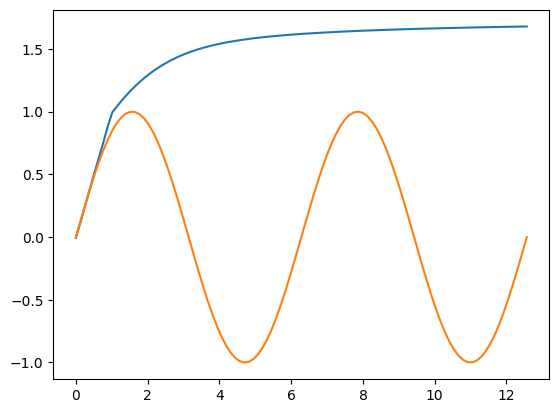

In [ ]:
test = torch.linspace(0*3.1415,4*3.1415, n)
output = torch.zeros(n)

for i in range(n):
    output[i] = model1(test[i].view(-1,1))
    
test = test.detach().numpy()

plt.plot(test, output.detach().numpy())   
plt.plot(test, np.sin(test))
plt.show()
#Oh no it seems our Model is lacking in expressivity, what could we improve?